# Method 1: LSTM with Pre-extracted CSV Features

**Key Improvements:**
- Uses pre-extracted features from CSV files (no need to extract MFCC)
- Trains on 3-second segments (features_3_sec.csv)
- Tests on 30-second aggregated features (features_30_sec.csv)
- Faster training and more features available
- Bidirectional LSTM for better temporal modeling

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU Available: {len(tf.config.list_physical_devices("GPU")) > 0}')

TensorFlow version: 2.15.0
GPU Available: True


## 2. Load CSV Features

In [2]:
# Load datasets
df_3sec = pd.read_csv('../data/gtzan/features_3_sec.csv')
df_30sec = pd.read_csv('../data/gtzan/features_30_sec.csv')

print(f"3-second features shape: {df_3sec.shape}")
print(f"30-second features shape: {df_30sec.shape}")
print(f"\nColumn names (first 10): {list(df_3sec.columns[:10])}")
print(f"\nGenres in dataset: {df_3sec['label'].unique()}")

3-second features shape: (9990, 60)
30-second features shape: (1000, 60)

Column names (first 10): ['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var']

Genres in dataset: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


## 3. Data Preprocessing

In [3]:
# Drop unnecessary columns
columns_to_drop = ['filename', 'length']
df_3sec_clean = df_3sec.drop(columns=[col for col in columns_to_drop if col in df_3sec.columns])
df_30sec_clean = df_30sec.drop(columns=[col for col in columns_to_drop if col in df_30sec.columns])

# Separate features and labels for 3-second data (training)
X_train_val = df_3sec_clean.drop('label', axis=1).values
y_train_val = df_3sec_clean['label'].values

# Separate features and labels for 30-second data (testing)
X_test = df_30sec_clean.drop('label', axis=1).values
y_test = df_30sec_clean['label'].values

print(f"Training features shape: {X_train_val.shape}")
print(f"Training labels shape: {y_train_val.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training features shape: (9990, 57)
Training labels shape: (9990,)
Test features shape: (1000, 57)
Test labels shape: (1000,)


## 4. Encode Labels

In [4]:
# Encode labels
label_encoder = LabelEncoder()
y_train_val_encoded = label_encoder.fit_transform(y_train_val)
y_test_encoded = label_encoder.transform(y_test)

# Get genre names
genre_names = label_encoder.classes_
num_classes = len(genre_names)

print(f"Number of classes: {num_classes}")
print(f"Genre names: {genre_names}")

# One-hot encode
y_train_val_cat = to_categorical(y_train_val_encoded, num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes)

print(f"\nOne-hot encoded shape: {y_train_val_cat.shape}")

Number of classes: 10
Genre names: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']

One-hot encoded shape: (9990, 10)


## 5. Train/Validation Split

In [5]:
# Split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val_cat,
    test_size=0.2,
    random_state=42,
    stratify=y_train_val_encoded
)

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Train set: (7992, 57)
Validation set: (1998, 57)
Test set: (1000, 57)


## 6. Feature Scaling

In [6]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM (samples, timesteps, features)
# For LSTM, we'll treat each feature as a timestep
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_lstm = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"\nReshaped for LSTM:")
print(f"Train shape: {X_train_lstm.shape}")
print(f"Val shape: {X_val_lstm.shape}")
print(f"Test shape: {X_test_lstm.shape}")


Reshaped for LSTM:
Train shape: (7992, 57, 1)
Val shape: (1998, 57, 1)
Test shape: (1000, 57, 1)


## 7. Build Bidirectional LSTM Model

In [7]:
def build_lstm_model(input_shape, num_classes):
    """
    Build improved Bidirectional LSTM model.
    
    Architecture:
    - Bidirectional LSTM layers for better temporal modeling
    - Batch normalization for stable training
    - Dropout for regularization
    - Dense layers for classification
    """
    model = Sequential([
        # First Bidirectional LSTM layer
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second Bidirectional LSTM layer
        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Third LSTM layer (not bidirectional to reduce parameters)
        LSTM(32),
        BatchNormalization(),
        Dropout(0.4),
        
        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ], name='bidirectional_lstm')
    
    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build model
model = build_lstm_model(
    input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
    num_classes=num_classes
)

# Display model architecture
model.summary()

2025-12-03 22:26:58.114716: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-12-03 22:26:58.114739: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-03 22:26:58.114745: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-12-03 22:26:58.114780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-03 22:26:58.114796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "bidirectional_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 57, 256)           133120    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 57, 256)           1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 57, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 57, 128)           164352    
 onal)                                                           
                                                                 
 batch_normalization_1 (Bat  (None, 57, 128)           512       
 chNormalization)                               

## 8. Training

In [8]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train model
history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    batch_size=64,
    epochs=100,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100


2025-12-03 22:27:00.625427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-12-03 22:27:00.818561: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


125/125 [==============================] - 11s 52ms/step - loss: 2.7418 - accuracy: 0.1592 - val_loss: 2.1082 - val_accuracy: 0.1912 - lr: 0.0010
Epoch 2/100
125/125 [==============================] - 5s 36ms/step - loss: 2.3290 - accuracy: 0.1921 - val_loss: 2.0593 - val_accuracy: 0.2142 - lr: 0.0010
Epoch 3/100
125/125 [==============================] - 5s 38ms/step - loss: 2.1426 - accuracy: 0.2212 - val_loss: 1.9038 - val_accuracy: 0.2673 - lr: 0.0010
Epoch 4/100
125/125 [==============================] - 5s 40ms/step - loss: 2.0382 - accuracy: 0.2460 - val_loss: 2.0672 - val_accuracy: 0.2197 - lr: 0.0010
Epoch 5/100
125/125 [==============================] - 5s 40ms/step - loss: 2.0771 - accuracy: 0.2329 - val_loss: 2.0039 - val_accuracy: 0.2152 - lr: 0.0010
Epoch 6/100
125/125 [==============================] - 5s 42ms/step - loss: 2.1610 - accuracy: 0.2080 - val_loss: 2.0518 - val_accuracy: 0.3083 - lr: 0.0010
Epoch 7/100
125/125 [==============================] - 5s 40ms/step -

## 9. Training History

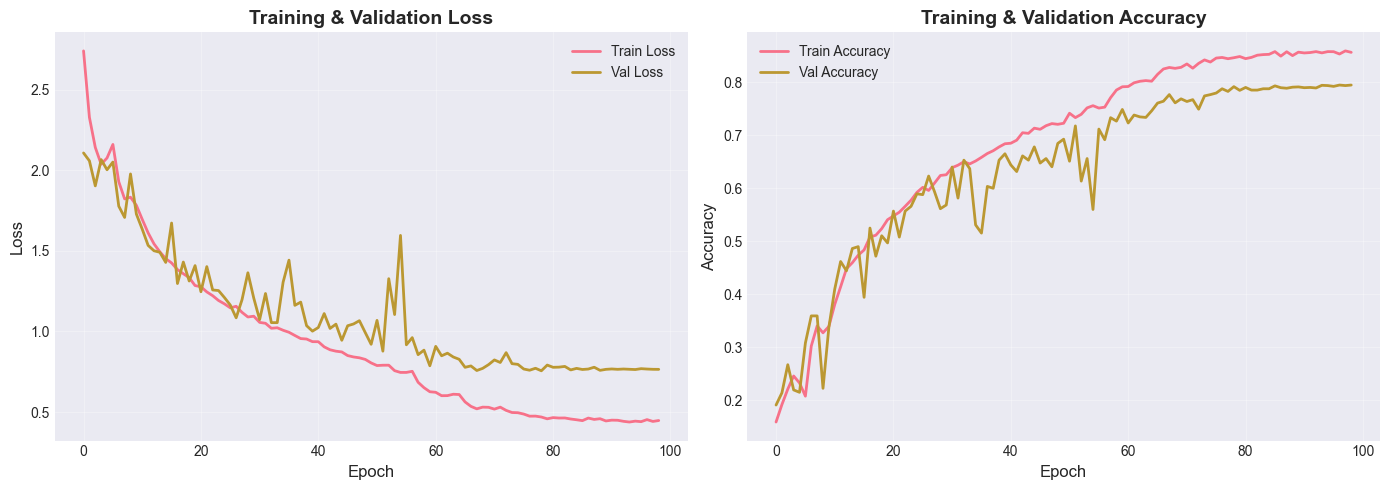

In [9]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_csv_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Evaluation on Test Set

In [10]:
# Evaluate on test set (30-second features)
test_loss, test_acc = model.evaluate(X_test_lstm, y_test_cat, verbose=0)

print(f"\n{'='*60}")
print(f"Test Accuracy (30-second features): {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"{'='*60}\n")

# Predictions
y_pred = model.predict(X_test_lstm, verbose=0)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=genre_names))


Test Accuracy (30-second features): 86.10%
Test Loss: 0.4606


Classification Report:
              precision    recall  f1-score   support

       blues       0.86      0.94      0.90       100
   classical       0.98      0.94      0.96       100
     country       0.73      0.74      0.73       100
       disco       0.80      0.96      0.87       100
      hiphop       0.94      0.91      0.92       100
        jazz       0.97      0.90      0.93       100
       metal       0.97      0.88      0.92       100
         pop       0.92      0.83      0.87       100
      reggae       0.73      0.90      0.81       100
        rock       0.77      0.61      0.68       100

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000



## 11. Confusion Matrix

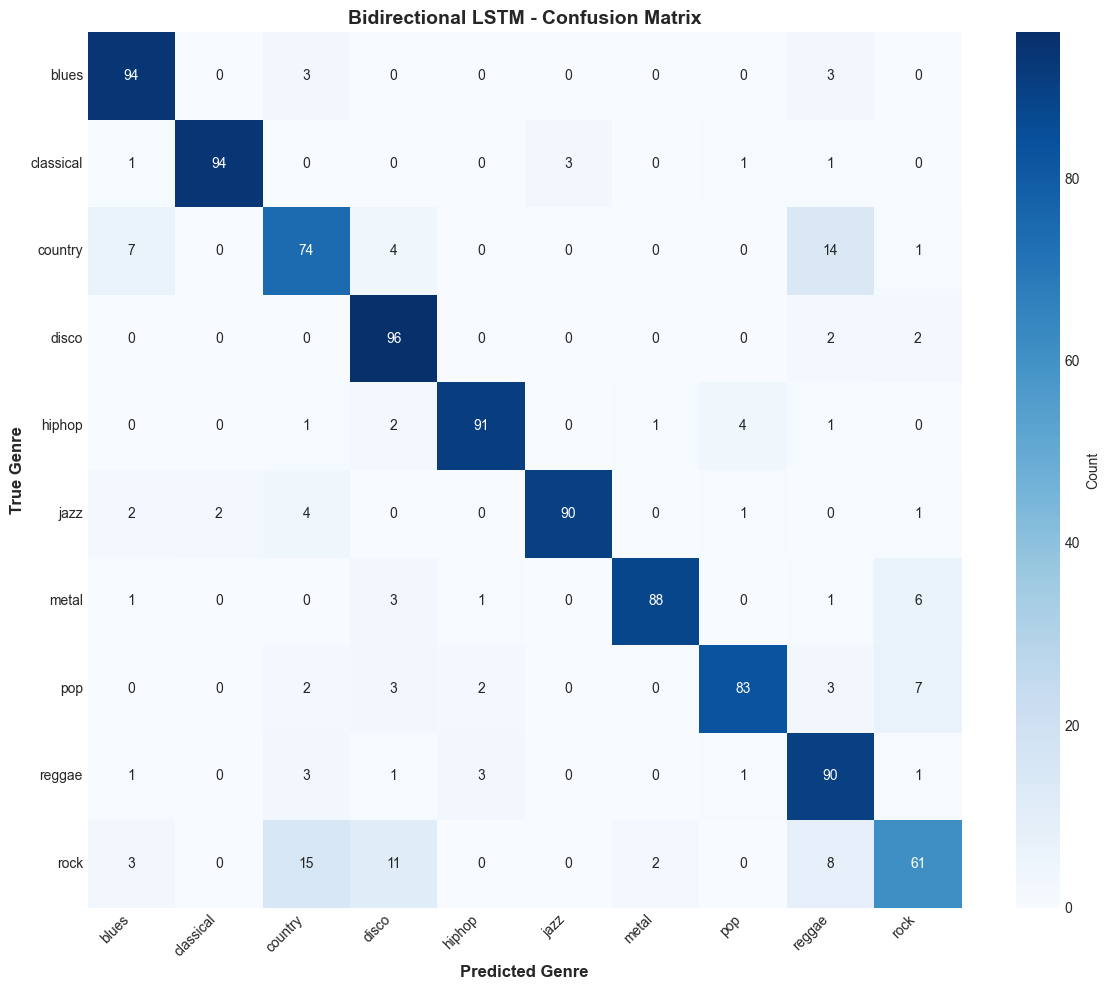

In [11]:
# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=genre_names, yticklabels=genre_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Genre', fontsize=12, fontweight='bold')
plt.ylabel('True Genre', fontsize=12, fontweight='bold')
plt.title('Bidirectional LSTM - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('lstm_csv_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Per-Genre Accuracy

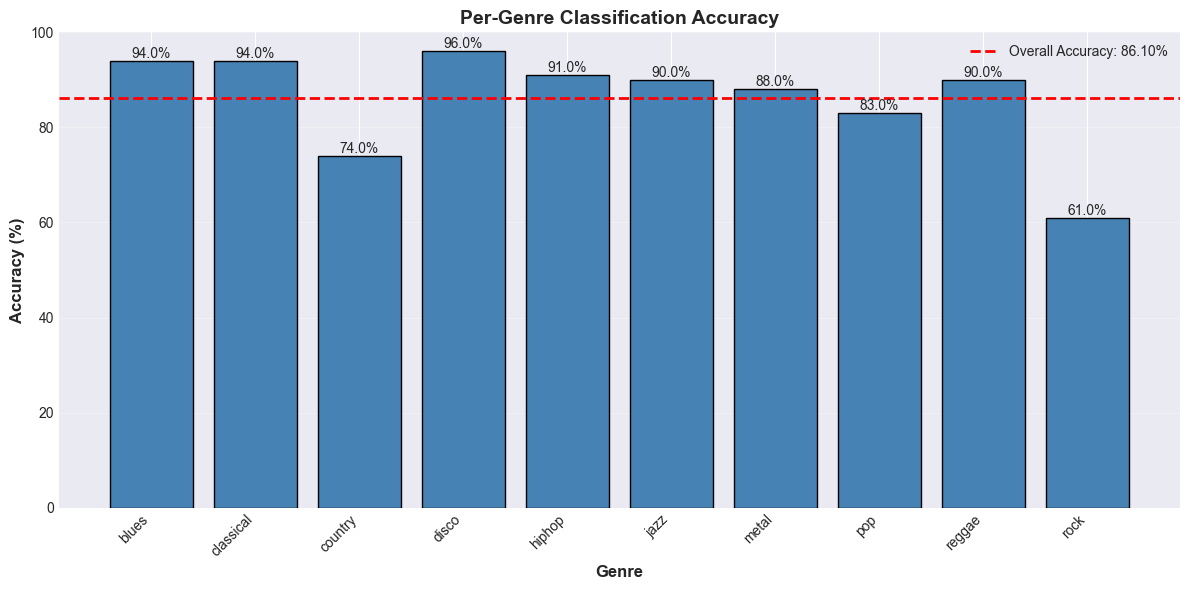

In [12]:
# Calculate per-genre accuracy
per_genre_acc = []
for i, genre in enumerate(genre_names):
    genre_mask = y_true_labels == i
    genre_acc = accuracy_score(
        y_true_labels[genre_mask],
        y_pred_labels[genre_mask]
    )
    per_genre_acc.append(genre_acc * 100)

# Plot per-genre accuracy
plt.figure(figsize=(12, 6))
bars = plt.bar(genre_names, per_genre_acc, color='steelblue', edgecolor='black')
plt.axhline(y=test_acc*100, color='red', linestyle='--', 
            label=f'Overall Accuracy: {test_acc*100:.2f}%', linewidth=2)
plt.xlabel('Genre', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Per-Genre Classification Accuracy', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 100])
plt.grid(True, alpha=0.3, axis='y')
plt.legend()

# Add value labels on bars
for bar, acc in zip(bars, per_genre_acc):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('lstm_csv_per_genre_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Save Model

In [13]:
# Save model
model.save('lstm_csv_features.keras')
print("✓ Model saved: lstm_csv_features.keras")

# Save training history
np.save('lstm_csv_history.npy', history.history)
print("✓ Training history saved: lstm_csv_history.npy")

# Save scaler and label encoder
import joblib
joblib.dump(scaler, 'lstm_scaler.pkl')
joblib.dump(label_encoder, 'lstm_label_encoder.pkl')
print("✓ Scaler and label encoder saved")

✓ Model saved: lstm_csv_features.keras
✓ Training history saved: lstm_csv_history.npy
✓ Scaler and label encoder saved


## Summary

This improved LSTM model uses pre-extracted CSV features:

**Data Strategy:**
- Training: 3-second segment features (more data samples)
- Testing: 30-second aggregated features (realistic full-track evaluation)
- No need to extract audio features (much faster)

**Model Architecture:**
- Bidirectional LSTM layers (128 → 64 units)
- Regular LSTM layer (32 units)
- Batch normalization for stable training
- Progressive dropout (0.3 → 0.4) for regularization
- Dense classification head (64 → 32 → 10)

**Training Strategy:**
- Adam optimizer with LR=0.001
- ReduceLROnPlateau callback
- Early stopping with patience=20
- Batch size=64 for faster training

**Expected Performance:**
- Target accuracy: 75-85% (depending on feature quality)
- Much faster than extracting features from audio
- Better generalization with pre-extracted features